# ANN 2022 Retinopathy Classification Problem
This code trains model and visualize some of the outputs.

## Drive Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/codespace/ann2022_project
%pwd

/content/drive/MyDrive/codespace/ann2022_project


'/content/drive/MyDrive/codespace/ann2022_project'

## Import and Setup Configurations

In [3]:
!pip install -q tensorflow-addons
!pip install -U -q imgaug

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import metrics, optimizers

from src import (
    build_googlenet, load_train_dataset, calculate_result, Configuration, build_optimizer, get_today, plot_auc_acc, plot_loss_acc, plot_loss_auc
)

config = Configuration()
tf.random.set_seed(config.seed)

if config.output_dir is None:
    config.output_dir = f"models/{get_today()}"

In [5]:
config.optimizer = "adam"
config.scheduler = "plateau"
config.batch_size = 16
config.label_smoothing = .3
config.use_augmentation = False

## Train

### Build models and Dataset

In [6]:
model = build_googlenet()
train_ds, valid_ds = load_train_dataset(config)

Found 1179 files belonging to 2 classes.
Using 944 files for training.
Found 1179 files belonging to 2 classes.
Using 235 files for validation.


In [7]:
steps_per_epoch = len(train_ds)
optimizer = build_optimizer(config, steps_per_epoch)

Adam optimizers were used with initial learning rate of $10^{-3}$ and weight decay with $10^{-2}$. This was optimal.

In [8]:
model.compile(
  optimizer=optimizer,
  loss=tf.losses.BinaryCrossentropy(
      label_smoothing=config.label_smoothing,
      name="bce"
  ),
  metrics=['accuracy', tf.keras.metrics.AUC()]
)

Early stopping criterion was used. Default setup for this was to 

### Callbacks

In [9]:
callbacks = []
if config.early_stop:
  callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config.patience))

if config.scheduler == "plateau":
  callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=.2, patience=config.patience, min_lr=1e-5))

callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        config.output_dir + "/ckpts/{epoch:02d}-{val_auc:.2f}.hdf5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
    )
)

callbacks.append(
    tf.keras.callbacks.CSVLogger(
        config.output_dir + "hist.csv",
        separator=",",
        append=True,
    )
)

### Train

In [ ]:
hist = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=config.epochs,
  callbacks=callbacks
)
config.save(config.output_dir)

Epoch 1/50
59/59 [==============================] - 31s 345ms/step - loss: 0.7023 - accuracy: 0.5466 - auc: 0.4637 - val_loss: 0.6940 - val_accuracy: 0.4936 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 21s 328ms/step - loss: 0.6891 - accuracy: 0.5498 - auc: 0.4908 - val_loss: 0.6947 - val_accuracy: 0.4936 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 21s 327ms/step - loss: 0.6908 - accuracy: 0.5498 - auc: 0.4996 - val_loss: 0.6944 - val_accuracy: 0.4936 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 22s 337ms/step - loss: 0.6904 - accuracy: 0.5498 - auc: 0.4980 - val_loss: 0.6939 - val_accuracy: 0.4936 - val_auc: 0.5259 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 22s 335ms/step - loss: 0.6811 - accuracy: 0.5498 - auc: 0.7013 - val_loss: 0.6697 - val_accuracy: 0.4936 - val_auc: 0.8559 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 22s 337m

## Result

### AUC, Classification Report

In [25]:
auc, report, cf = calculate_result(model, train_ds, "train")
auc, report, cf = calculate_result(model, valid_ds, "valid")

TRAIN
AUC: 0.9467
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83       519
         1.0       0.75      0.94      0.83       425

    accuracy                           0.83       944
   macro avg       0.84      0.84      0.83       944
weighted avg       0.85      0.83      0.83       944

[[387 132]
 [ 27 398]]
VALID
AUC: 0.9555
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.83       116
         1.0       0.80      0.95      0.87       119

    accuracy                           0.85       235
   macro avg       0.87      0.85      0.85       235
weighted avg       0.86      0.85      0.85       235

[[ 87  29]
 [  6 113]]


In [27]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1', 'lr'])

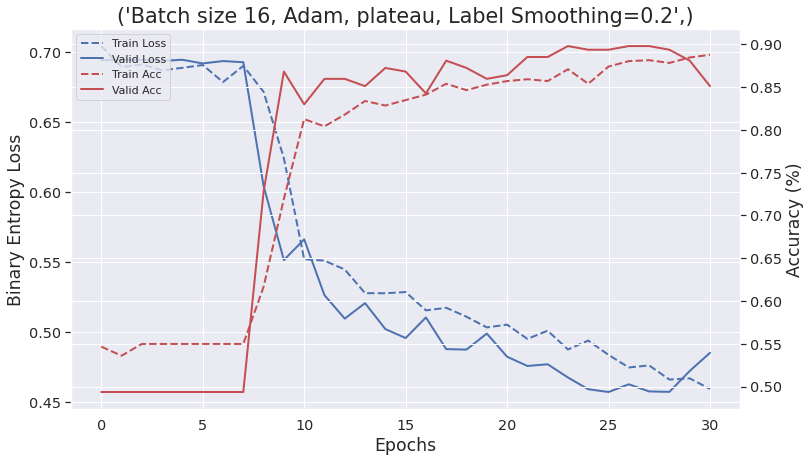

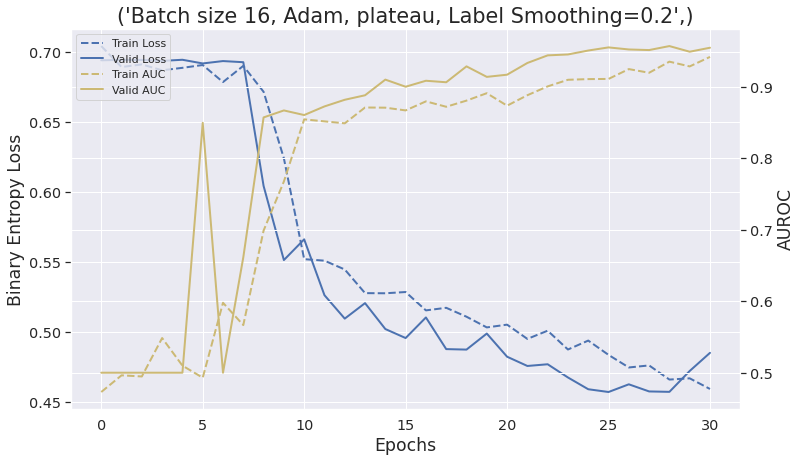

KeyError: ignored

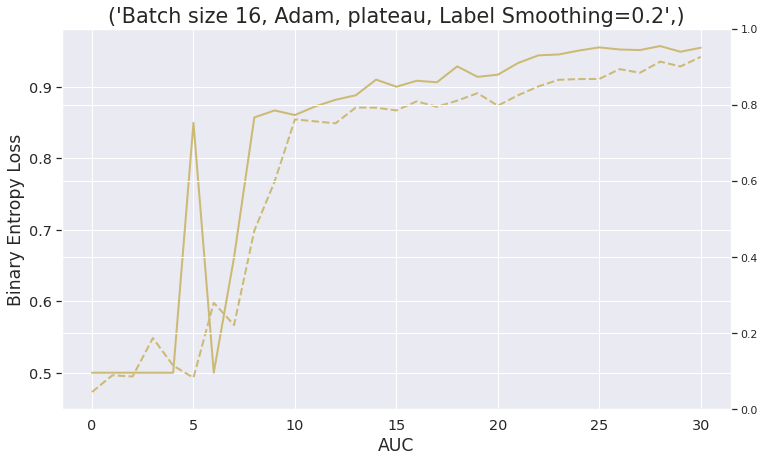

In [28]:
title = f"Batch size {config.batch_size}, {config.optimizer.capitalize()}, {config.scheduler}, Label Smoothing={config.label_smoothing}",

if "auc" not in hist.history.keys():
  hist.history["auc"] = hist.history["auc_1"] 
  hist.history["val_auc"] = hist.history["val_auc_1"] 

plot_loss_acc(hist, title, config.output_dir)
plot_loss_auc(hist, title, config.output_dir)
plot_auc_acc(hist, title, config.output_dir)

In [14]:
# model.save(config.output_dir)
config.save(config.output_dir)

## Decision Visualization

In [23]:
!pip install tf-explain

     |████████████████████████████████| 43 kB 1.9 MB/s 


In [19]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])